<span style="font-size:2em;"> Homogeneous Devices</span>

<span style="font-size:1.5em;">The following codes demonstate an example QCloudSim with homogeneous quantum devices where all the resources are declared identical. The settings are simpler than hetrogeneous quantum devices. The setup includes a broker, a job generator and a QCloud. A broker is responsible for assigning the incoming jobs to resources with FIFO scheduling algorithm.</span>

In [12]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from QJob import QJob
from JobLogger import JobLogger
from helperfun import *
from helperfun import INTERVAL
from datetime import datetime

In [13]:
class QCloud(object):
    """
    A quantum cloud has a limited number of machines (``NUM_MACHINES``) to
    process jobs in parallel.

    Jobs have to request one of the machines. When they got one, they
    can start the processes and wait for it to finish (which
    takes ``jobtime`` minutes).

    """
    def __init__(self, env, num_machines):
        self.env = env
        self.machine = simpy.PriorityResource(env=env, capacity=num_machines)
        
    def execute(self, qjob):
        """The job processes. """
        est_time = estimate_time(qjob, "", random.randint(4000, 5000))
        printLog(f"Job {qjob._id}\'s estimate time is {est_time:.2f}.", PrintLog)
        yield self.env.timeout(est_time)
        printLog(f"Job {qjob._id} processed with {random.randint(70, 99)}% of accuracy.", PrintLog)

In [14]:
class Broker(object):
    
    def __init__(self, env, prioritize):
        self.env = env
        self.prioritize = prioritize
        
    def schedule(self, qcloud, qjob, joblogger): 
        printLog(f'{qjob._id} arrives at the central queue at {self.env.now:.2f}.', PrintLog)
        arrival_time = self.env.now
        
        if not self.prioritize: 
            qjob.priority = 2    
        
        with qcloud.machine.request(priority = qjob.priority) as request:
            yield request
            
            wait_time = self.env.now - arrival_time
            joblogger.wait_time.append(wait_time)
            
            printLog(f'{qjob._id} enters the qdevice at {self.env.now:.2f} with priority {qjob.priority}.', PrintLog)
            yield self.env.process(qcloud.execute(qjob))

            printLog(f'{qjob._id} leaves the qdevice at {self.env.now:.2f}.', PrintLog)
            joblogger.num_of_completed_jobs += 1

In [15]:
def setup(env, num_machines, joblogger):
    """Create a quantum cloud, a broker and on going jobs
    approx. every INTERVAL minutes."""
    
    # initialize a quantum cloud
    qcloud = QCloud(env, num_machines)
    
    # initialize a broker
    # set prioritize = True for priority scheduling
    # False for FIFO scheduling
    
    broker = Broker(env = env, prioritize = False)

    # Create jobs while the simulation is running

    i = 0
    while True:
        yield env.timeout(incoming_job_interval())
        i += 1
        qjob = QJob(env, i)
        env.process(broker.schedule(qcloud, qjob, joblogger))
        

In [16]:
data = {}

SIM_TIME = 10000
PrintLog = False # Detail Logs

# Setup and start the simulation
print(f'Simulation Started at {datetime.now()}')
sim_start_time = time.time()

for NUM_MAC in range(1, 9): 
    RANDOM_SEED = random.randint(2, 10000)
    random.seed(RANDOM_SEED)  # This helps to reproduce the results

    joblogger = JobLogger()

    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_MAC, joblogger))

    # Execute!
    env.run(until=SIM_TIME)
    data[NUM_MAC] = joblogger.wait_time

print(f'Simulation Ended at {datetime.now()}')
sim_end_time = time.time()
print(f'Elasped time - {sim_end_time-sim_start_time:.5f}')

Simulation Started at 2024-04-13 13:12:00.760315
Simulation Ended at 2024-04-13 13:12:01.024006
Elasped time - 0.26306


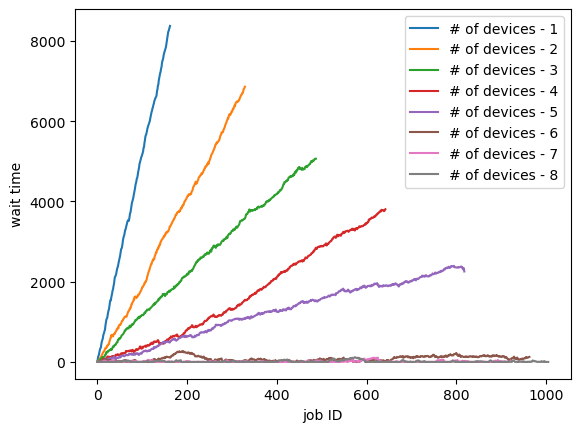

In [17]:
for i in range(1, 9): 
    plt.plot(data[i])

plt.legend(['# of devices - 1', 
            '# of devices - 2', '# of devices - 3', 
            '# of devices - 4', '# of devices - 5', 
            '# of devices - 6', '# of devices - 7', 
            '# of devices - 8', '# of devices - 9'])
plt.xlabel('job ID')
plt.ylabel('wait time')
plt.show()